# General information

## Study background

A novel seismic survey was conducted in Blötberget (central Sweden) to test and validate new tools for mineral exploration in hardrock settings. A combination of collocated MEMs (micro-electromechanical sensors), 3-component geophones, surface and borehole distributed acoustic sensing (DAS) was used to image a well-known mineralization horizon.

<img src="mineralDAS.png" alt="mineralDAS-2" width="600"/>

DAS has received a lot of attention in the last decade. Numerous studies have been conducted using passive data (Li et al., 2021 and references therein) and several successful examples of DAS-VSP surveys for CO2 storage monitoring (e.g. Götz et al., 2018; Freifeld et al. 2021) have also been presented. Bellefleur et al. (2019) demonstrated the potential of DAS-VSP to illuminate reflections from a deposit in Canada and Urosevic et al. (2019) deployed surface DAS for a seismic survey aiming at imaging mineral resources under a salty lake in Western Australia. Nonetheless, given the challenge of acquiring and understanding DAS data, little has been done combining surface and borehole DAS and collocating it with conventional geophones for better scrutinization. The goal of this study is therefore to validate the use of DAS for this particular purpose and compare the results with the data recorded by the geophones on the surface and existing legacy datasets from the site.

## About the data

The data recorded by the fibre are stored in h5 files that correspond to 30s of recording. The h5 contains the raw data, sampled at 20 000 Hz. The time stamp of the file doesn't correspond to the shot's time stamp. Our ultimate goal is to compare the DAS data with the MEMs recordings and hopefully retrieve a similar picture. The MEMs data for the same shot is shown in the figure below, with the signal from the mineralization highlighted by the arrows:


<img src="shot995MEMSmin.png" alt="shot995MEMSmin" width="600"/>


We aim at producing a similar figure for the DAS data.

## About this code

We want to retrieve the data corresponding to one vibroseis shot and compare it to the same shot recorded by MEMs. For this, we need to execute the following steps:

1. Read the data from the h5 file
2. Resample to 1 kHz
3. Extract 25s long section of the data starting from the shot timestamp. If necessary, append the missing data from the next file.
4. Cross-correlate with theoretical sweep from the vibroseis truck.
5. Clip the data to 5 s after the shot timestamp
6. Save it as a seg-y or seg-d file.

***

# The code:

In [62]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import datetime
from scipy import signal
%matplotlib inline

### Accessing DAS data

- reading the h5-file that contains our shot

In [3]:
# Directory, filename
cwd = os.getcwd()
filename = "/0000004138_2022_06_18_18_44_29_17159.hdf5"
ff = cwd+filename

# Read h5 file
f = h5py.File(ff,'r')
print('Keys in file: ', list(f.keys()))

Keys in file:  ['DAQ', 'DAS', 'Interrogator', 'Metadata', 'ProcessingServer']


### Reading data and metadata of HDF5 file
- printing keys to understand what information is included
- the fibre data is stored as a matrix in the 'DAS' group
- the data contains 30s of recording at 20'000 Hz (600'000 samples) for 448 channels (448 points along the 2,2 km-long fibre)

In [4]:
# Read data and metadata
DAQ = f['DAQ']
DAS = f['DAS']
interrogator = f['Interrogator']
metadata = f['Metadata']
processing_server = f['ProcessingServer']

print('shape of DAQ, DAS, interrogator: ',np.shape(DAQ),np.shape(DAS),np.shape(interrogator))
print('shape of metadata, processing server: ',np.shape(metadata),np.shape(processing_server))

shape of DAQ, DAS, interrogator:  (34,) (600000, 448) (28,)
shape of metadata, processing server:  (15,) (18,)


In [5]:
print('metadata keys: ',metadata.keys(),'\n')
print('DAQ keys: ', DAQ.keys(),'\n')
print('Interrogator keys: ',interrogator.keys(),'\n')
print('Processing server keys: ', processing_server.keys(),'\n')

metadata keys:  <KeysViewHDF5 ['BlockCount', 'CompressedMode', 'Country', 'FirstFileName', 'Location', 'Name', 'NextFileName', 'PreviousFileName', 'Throughput', 'Timestamp', 'Timezone', 'TimezoneName', 'TimezoneSupportsDaylightSaving', 'TraceCount', 'ZeroOffset']> 

DAQ keys:  <KeysViewHDF5 ['ACCoupled', 'BandwidthLimiterEnabled', 'BaseCardVersion', 'ChannelCount', 'ClockFrequency', 'ClockOutputEnabled', 'Driver', 'DriverVersion', 'ExtendedModuleVersion', 'ExternalClockEnabled', 'FiftyOhmEnabled', 'InputPathEnabled', 'InstalledMemory', 'KernelVersion', 'MaximumSamplingRate', 'ModuleVersion', 'MultipleTriggerEnabled', 'PositionEnd', 'PositionStart', 'ProductionDate', 'ReferenceCoilRecorded', 'RepetitionFrequency', 'SampleEnd', 'SampleStart', 'SamplingInterval', 'SamplingRate', 'SerialNumber', 'SpatialPoints', 'TriggerACCoupleEnabled', 'TriggerAnalogModeEnabled', 'TriggerFiftyOhmEnabled', 'TriggerLevel', 'Type', 'VoltageRange']> 

Interrogator keys:  <KeysViewHDF5 ['ActiveOpticalChannelN

In [6]:
print('Timestamp: ', metadata['Timestamp'][0])
print('Fibre length (in m): ', interrogator['FiberLength'][0])
print('Data type: ', processing_server['DataType'][0])

timestamp:  b'2022-06-18T18:44:29.171593Z'
Fiber length (in m):  2201.989990234375
Data type:  b'PHASE'


### Getting index of the shot timestamp

- manually entering shot time -> will be improved in the future
- getting the time stamp of the file from filename
- finding and indexing the start time of our shot in the DAS recording

**!!! The indexing of the starting sample might need to be improved. If dt is exactly between two samples, there will be two minima.**

In [51]:
# Time stamp of the shot (manual input for now)
tshot = datetime.datetime(2022,6,18,18,44,34,948004)

# Time stamp of h5 file
t_f = filename.split("_")
t_f7 = t_f[7].split(".");
tfile = datetime.datetime(int(t_f[1]),int(t_f[2]),int(t_f[3]),int(t_f[4]),int(t_f[5]),int(t_f[6]),int(t_f7[0]))
print("Time stamp of shot:", tshot, ", Time stamp of file: ", tfile)

# Difference between both time stamps
dt = round(tshot.timestamp()-tfile.timestamp(),6)

# Sampling rate (in s)
ts = 1/DAQ['RepetitionFrequency'][0]

# Time vector for file [0:ts:30]
t_samp = np.linspace(0,np.shape(DAS)[0]*ts,num=np.shape(DAS)[0])

# Which sample corresponds to the start of the shot?
dt_abs = np.absolute(t_samp - dt)
ibeg = int(np.where(np.min(dt_abs) == dt_abs)[0])
tlen = 5 # recording length we want to keep after shot start
iend = int(ibeg + tlen / ts)
print(iend)

Time stamp of shot: 2022-06-18 18:44:34.948004 , Time stamp of file:  2022-06-18 18:44:29.017159
218617


## Plot of the raw data (entire DAS matrix)
- the red line corresponds to the timestamp of the sweep
- the blue line corresponds to the end of the data we want to extract

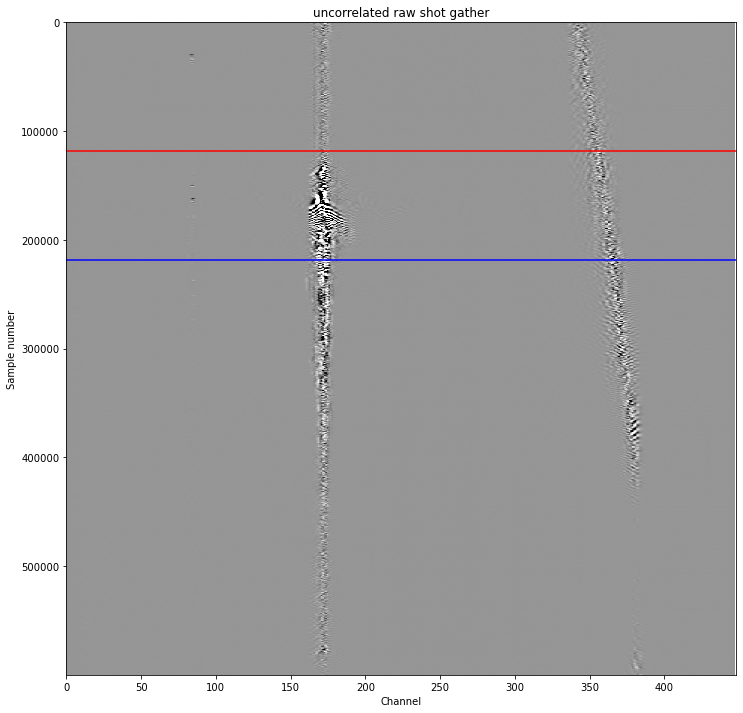

In [61]:
nchan = np.shape(DAS)[1]

fig = plt.figure(figsize=(12,12))
vmax = np.percentile(abs(DAS[:,:]),95)
plt.imshow(DAS[:,:], vmin=-vmax, vmax=vmax, cmap="Greys", aspect='auto')
plt.title('uncorrelated raw shot gather')
plt.hlines(tind,0,nchan,colors='r')
plt.hlines(tend,0,nchan,colors='b')
plt.xlim(0,nchan)
plt.xlabel('Channel')
plt.ylabel('Sample number')
plt.show()

## Resampling the data from 20'000 Hz to 1000 Hz

In [69]:
a, b = signal.butter(4, 500, 'low', analog=True)
sos = signal.butter(4, 500, 'low', fs=20000, output='sos')

DASfilt = signal.sosfilt(sos, DASn[])



## Extracting the shot data from DAS

We want to extract the data from the shot timestamp + 25 s because we want to correlate the signal with the theoretical sweep from the vibroseis truck, which itself is 25s long.  

In [54]:
nchan=448
DASn = DAS[ibeg:iend,0:nchan+1]
print(np.shape(DASn))

[[0 1]
 [2 3]
 [4 5]
 [6 7]]
(100000, 448)
l:  100000
118617
218617


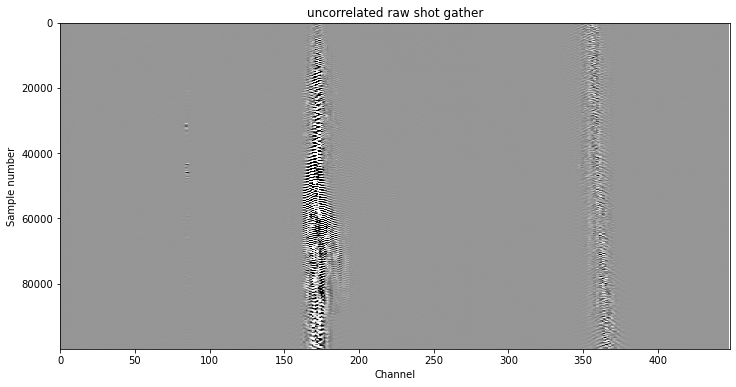

In [60]:
fig = plt.figure(figsize=(12,6))
vmax = np.percentile(abs(DASn[:,:]),95)
plt.imshow(DASn[:,:], vmin=-vmax, vmax=vmax, cmap="Greys", aspect='auto')
plt.title('uncorrelated raw shot gather')
#plt.hlines(tind,0,nchan,colors='r')
#plt.hlines(tend,0,nchan,colors='b')
plt.xlim(0,nchan)
plt.xlabel('Channel')
plt.ylabel('Sample number')
plt.show()

## Cross-correlation with theoretical sweep